### Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

%matplotlib inline
import sys
sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")

%load_ext autoreload

In [2]:
#Importing necessary modules:
import os
import sys
import copy

sys.path.insert(0,os.path.join('..','..'))
#sys.path.insert('../..')

import time
import numpy as np
import pylab as plt

# import auxiliar functions
%autoreload 2
from Auxiliary import *

### Input variables

In [51]:
''' crystal variables  '''
crystal_type='111'
ang_as = np.deg2rad(5)           # asymmetric angle

if crystal_type == '111':
    ''' Silicon 111 crystal '''
    d_sp = 3.13557135638            # reflecting plane d-spacing [A]
    psi0r = -5.11321939903e-05      # real part of 0th Fourier component of crystal polarizability
    psi0i = 3.58887560736e-06       # imaginary part of ""
    psi_hr = -2.71341902391e-05     # real part of Hth Fourier component
    psi_hi = 2.50565837652e-06      # imaginary part of ""
    psi_hbr = -2.71341902391e-05    # real part of -Hth Fourier coumponent
    psi_hbi = 2.50565837652e-06     # imaginary part of ""
    
if crystal_type == '220':
    ''' Silicon 220 crystal '''
    d_sp = 1.9201374688016222        # reflecting plane d-spacing [A]
    psi0r = -9.7640050694412e-06     # real part of 0th Fourier component of crystal polarizability
    psi0i = 1.4938680132506875e-07   # imaginary part of ""
    psi_hr = -5.932463856370471e-06  # real part of Hth Fourier component
    psi_hi = 1.44406950529943e-07    # imaginary part of ""
    psi_hbr = -5.932463856370471e-06 # real part of -Hth Fourier coumponent
    psi_hbi = 1.44406950529943e-07   # imaginary part of ""
    
tc = 0.01                        # crystal thickness
uc = 1                           # use case: 1 (Bragg reflection); 2 (Bragg transmission)
ang_dif_pl = 0                   # diffraction plane angle: 0 (vertical); pi/2 (horizontal)
Temp_Crystal = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as,_uc=uc)

# lens parameters (PMMA)
n = 1 - 5.89e-6         # material refractive index
#d_abs = 788e-6          # material absorption depth
d_abs = 1
f_lens = 1              # lens focal distance

# aperture parameters
Apt_width = 1000e-6      # aperture width (1D)
acentx = 0              # center of aperture [m]
acenty = 0

''' incident beam variables '''
ekev = 10.0                 # photon energy [kev]
pulse_duration = 0.1e-15    # pulse duration (rms) [t]
z1 = 200.0                  # distance to first OE [m]
sigX = 50e-6/2.36           # w0 (rms) [m]
npoints = 5000              # wavefront sampling dimension
if_load_input = 0           # load (1) or generate (0) incident wavefront

# default values
qnC = 0.1                   # charge [nC]
pulseEnergy = 0.5e-3        # pulse energy [J]
dt = 0.5e-15                # time sampling resolution
if pulse_duration/dt <= 10:
    print('incident beam too short, changing to finer sampling resolution ...')
    dt = 0.1e-15
    if pulse_duration/dt <= 10:
        print(".... okay, the beam is really too short, simulation might break down")
hbar = 6.582119569e-16

# input dimensions
npointsx = 2                # number of points vs horizontal position
npointsy = npoints          # """"""""""""""""""  vertical position

incident beam too short, changing to finer sampling resolution ...
.... okay, the beam is really too short, simulation might break down


### Calculate sampling parameters

In [52]:
''' calculations '''
wl0 = E2L(ekev*1e3)                 # wavelength
k0 = 2*np.pi/wl0                    # wavenumber
divergence = wl0/np.pi/sigX         # paraxial beam divergence (rms)
range_xy = divergence/2 * z1 * 10    # spatial sampling range (5 sigma)

nvx0, nvy0, nvz0 = Temp_Crystal.find_orient(ekev*1e3,ang_dif_pl)[0][2]
thetaB0 = np.arctan(-nvz0/nvy0)+ang_as

trange = calc_stretching(thetaB0, ang_as, range_xy)    # stretched pulse duration
pulseRange = trange/pulse_duration

if pulseRange < 400:
    pulseRange = 400
    trange = pulse_duration * pulseRange

if trange > 1000e-15:
    trange = 1000e-15
    pulseRange = trange/pulse_duration

if trange < 300e-15:
    trange = 300e-15
    pulseRange = trange/pulse_duration

dev = 1/trange * 2*np.pi * hbar     # photon energy sampling resolution
nz = int(trange/dt)                 # number of photon energy slices
if nz % 2!=0:
    nz += 1
    
''' diffraction limit and focal spot Rayleigh range '''
thetamax = 2*np.arctan(divergence/2*z1*3/f_lens)
dlim = wl0/2/n/np.sin(thetamax)     # diffraction limit
zR = 1/2 * k0 * dlim**2             # focal spot Rayleigh range

print('beam parameters:\n    {}keV, {}fs, {}um w0, {}urad divergence'.format(
    ekev, round(pulse_duration*1e15,2), round(sigX*1e6,2), round(divergence*1e6,2)))
print('sampling parameters:\n    {}fs dt, {}meV deV, {} nz, {} pulseRange'.format(
    round(dt*1e15,2), round(dev*1e3,2), nz, round(pulseRange,2)))
print('other parameters:\n    Bragg angle {}deg, stretched pulse length {}fs'.format(
    round(np.rad2deg(thetaB0),2),round(trange*1e15,2)))
print('diffraction limit {}um, Rayleigh range {}mm, Fresnel distance {}um'.format(
    round(dlim*1e6,2), round(zR*1e3,2), round((3e8*0.1e-15)**2/wl0*1e6,2)))


beam parameters:
    10.0keV, 0.1fs, 21.19um w0, 1.86urad divergence
sampling parameters:
    0.1fs dt, 4.14meV deV, 10000 nz, 10000.0 pulseRange
other parameters:
    Bragg angle 11.42deg, stretched pulse length 1000.0fs
diffraction limit 0.06um, Rayleigh range 0.08mm, Fresnel distance 7.25um


In [53]:
''' directories '''
# output data directory
strDataFolderName = 'WPG_output/Hasan_Mono/' 
if not os.path.exists(strDataFolderName):
    mkdir_p(strDataFolderName)

# sub-folder for current sampling parameters
dirname_duration = strDataFolderName+'Si_{}_{}fs_beam/'.format(
    crystal_type,round(pulse_duration*1e15,1))
if not os.path.exists(dirname_duration):
    mkdir_p(dirname_duration)

# sub-sub-folder for incident beam
dirname_input = dirname_duration+'incident_beam/'
if not os.path.exists(dirname_input):
    mkdir_p(dirname_input)

# sub-sub-folder for propagated beam
dirname_prop = dirname_duration+'propagation/'
if not os.path.exists(dirname_prop):
    mkdir_p(dirname_prop)

''' filenames '''
name0 = 'incident'
name1 = 'cc1'
name2 = 'lens0'
name3 = 'apt'
name4 = 'lens1'
name5 = 'cc2'

fname_incident = dirname_input+'incident_compressed.h5'
fname_cc1 = dirname_prop+'wf_{}um_slit_{}_compressed.h5'.format(round(Apt_width*1e6,2),name1)
fname_l0  = dirname_prop+'wf_{}um_slit_{}_compressed.h5'.format(round(Apt_width*1e6,2),name2)
fname_apt = dirname_prop+'wf_{}um_slit_{}_compressed.h5'.format(round(Apt_width*1e6,2),name3)
fname_l1  = dirname_prop+'wf_{}um_slit_{}_compressed.h5'.format(round(Apt_width*1e6,2),name4)
fname_cc2 = dirname_prop+'wf_{}um_slit_{}_compressed.h5'.format(round(Apt_width*1e6,2),name5)


### Plot results

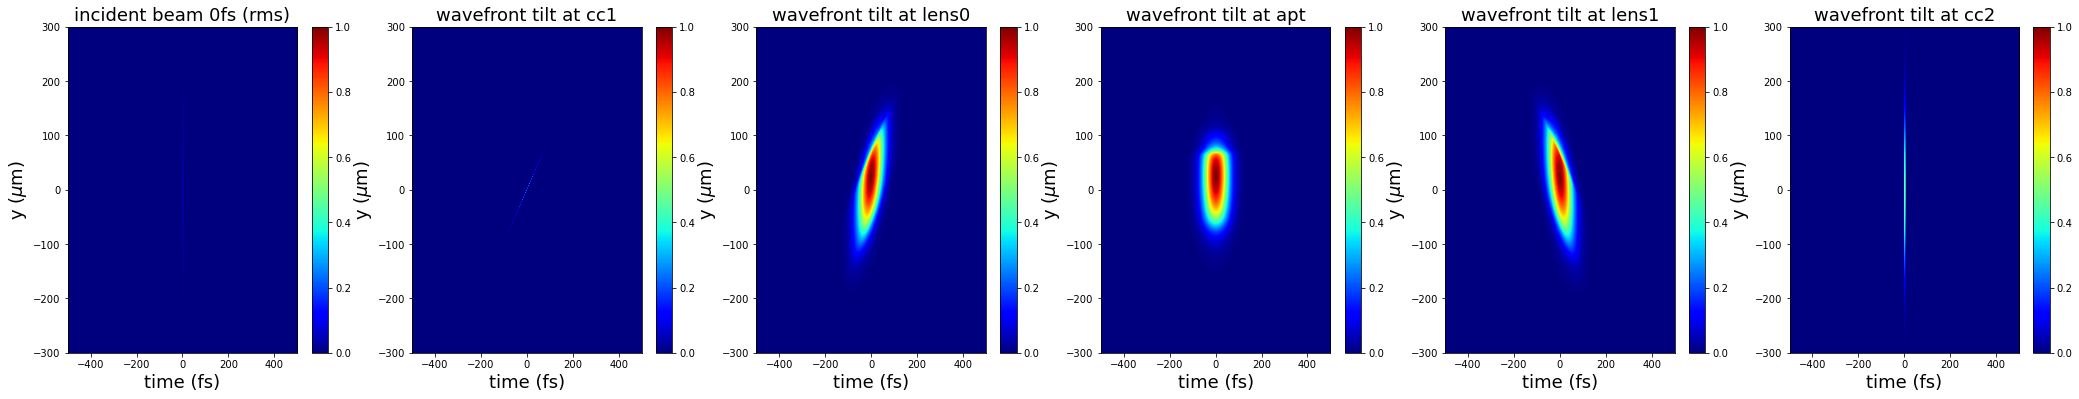

In [54]:
''' structure everywhere '''
ori = 'V'
if_log = 0
fov_y = 600    # um
fov_t = trange*1e15    # fs

plt.figure(figsize=(36,6))
# spatial temporal profile
plt.subplot(1,6,1)
plot_tilt_from_file(fname_incident,label=name0,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.title('incident beam {}fs (rms)'.format(round(pulse_duration*1e15)), fontsize=18)

plt.subplot(1,6,2)
plot_tilt_from_file(fname_cc1,label=name1,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,6,3)
plot_tilt_from_file(fname_l0,label=name2,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,6,4)
plot_tilt_from_file(fname_apt,label=name3,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,6,5)
plot_tilt_from_file(fname_l1,label=name4,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,6,6)
plot_tilt_from_file(fname_cc2,label=name5,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])

plt.savefig(dirname_prop+'wavefront_tilt_{}um_slit.png'.format(
    round(Apt_width*1e6,2)),transparent=True)


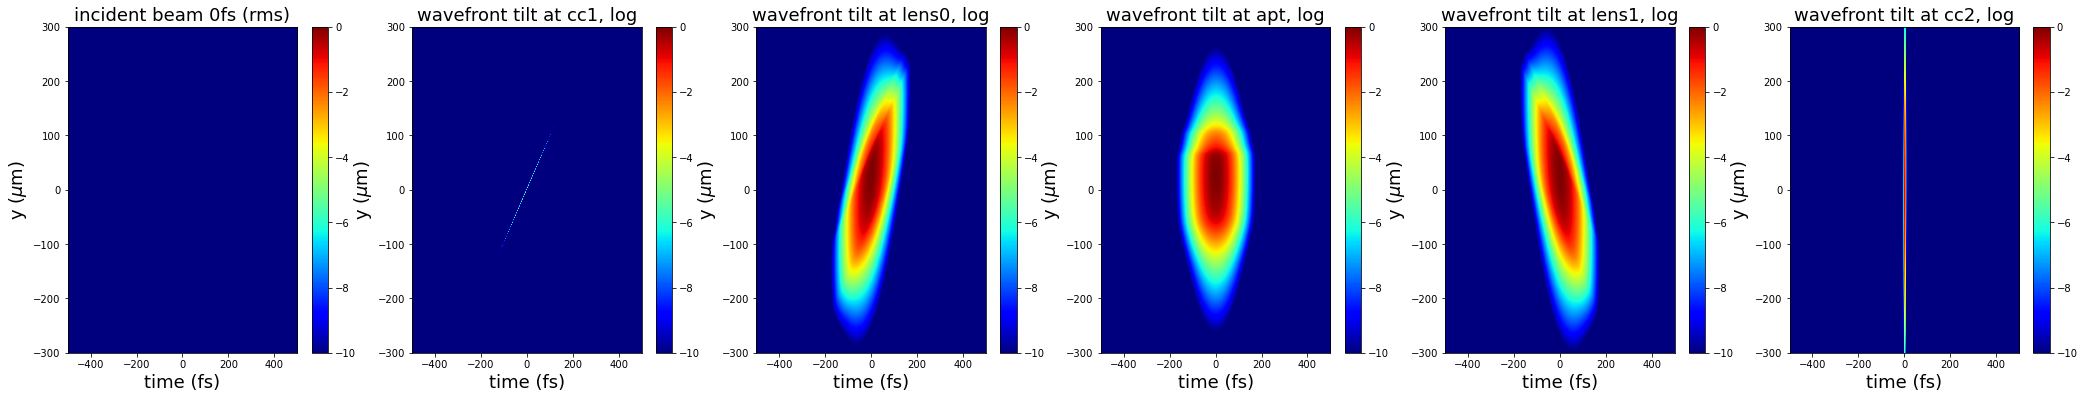

In [55]:
''' structure everywhere (log) '''
if_log = 1

plt.figure(figsize=(36,6))
# spatial temporal profile
plt.subplot(1,6,1)
plot_tilt_from_file(fname_incident,label=name0,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.title('incident beam {}fs (rms)'.format(round(pulse_duration*1e15)), fontsize=18)

plt.subplot(1,6,2)
plot_tilt_from_file(fname_cc1,label=name1,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,6,3)
plot_tilt_from_file(fname_l0,label=name2,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,6,4)
plot_tilt_from_file(fname_apt,label=name3,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,6,5)
plot_tilt_from_file(fname_l1,label=name4,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,6,6)
plot_tilt_from_file(fname_cc2,label=name5,if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])

plt.savefig(dirname_prop+'wavefront_tilt_{}um_slit_log.png'.format(
    round(Apt_width*1e6,2)),transparent=True)


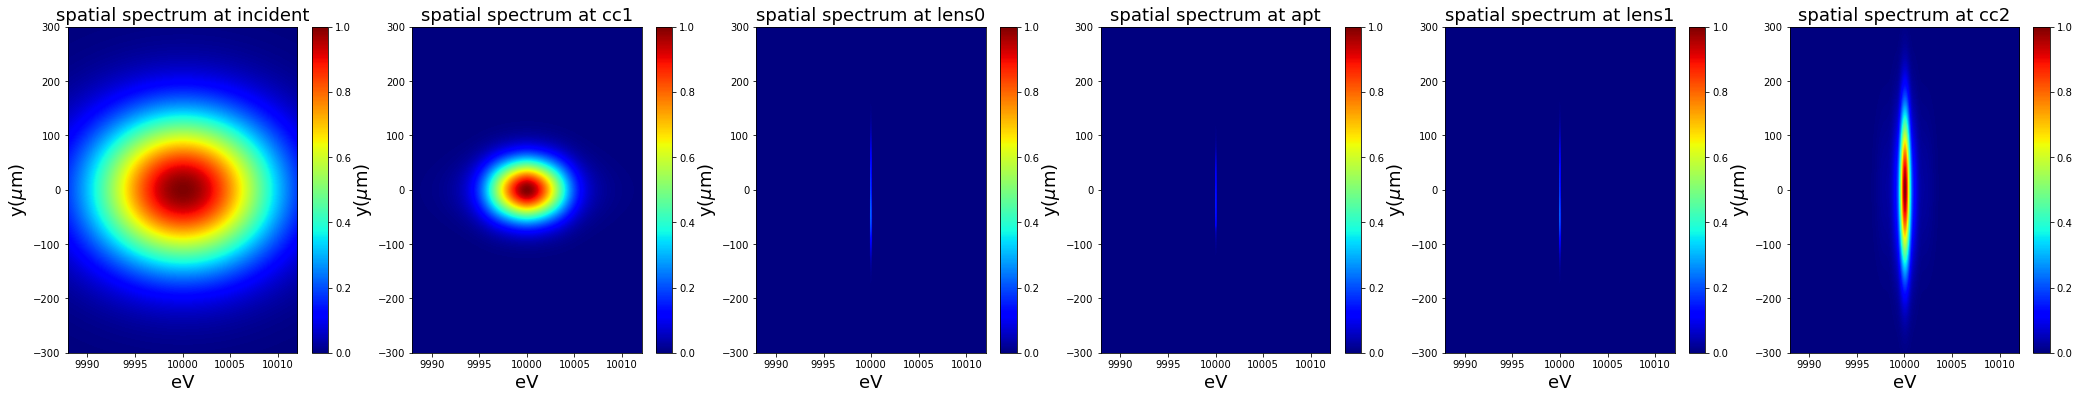

In [56]:
''' spatial spectrum everywhere '''
if_log = 0
aw, axis_ev, int_ev = get_spectra_from_file(fname_incident)

eRange = axis_ev.max()-axis_ev.min()
eMin = axis_ev[aw.min()]-eRange/20
eMax = axis_ev.max()-(eMin-axis_ev.min())

plt.figure(figsize=(36,6))
plt.subplot(1,6,1)
plot_tilt_freq_from_file(fname_incident,label=name0,if_log=if_log)
plt.xlim([eMin, eMax]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,6,2)
plot_tilt_freq_from_file(fname_cc1,label=name1,if_log=if_log)
plt.xlim([eMin, eMax]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,6,3)
plot_tilt_freq_from_file(fname_l0,label=name2,if_log=if_log)
plt.xlim([eMin, eMax]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,6,4)
plot_tilt_freq_from_file(fname_apt,label=name3,if_log=if_log)
plt.xlim([eMin, eMax]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,6,5)
plot_tilt_freq_from_file(fname_l1,label=name4,if_log=if_log)
plt.xlim([eMin, eMax]); plt.ylim([-fov_y/2,fov_y/2])

plt.subplot(1,6,6)
plot_tilt_freq_from_file(fname_cc2,label=name5,if_log=if_log)
plt.xlim([eMin, eMax]); plt.ylim([-fov_y/2,fov_y/2])

plt.savefig(dirname_prop+'spatial_spectrum_{}um_slit.png'.format(
    round(Apt_width*1e6,2)),transparent=True)


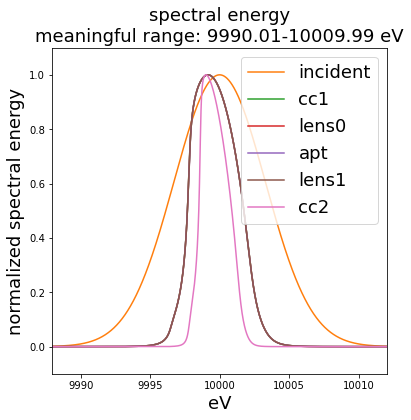

In [57]:
''' spectra everywhere '''
plt.figure(figsize=(6,6))
aw, evI, intIs = get_spectra_from_file(fname_incident)
plot_spectra(aw, evI, intIs, 'C1', label=name0)

_, evCC1, intCC1s = get_spectra_from_file(fname_cc1)
plot_spectra(aw,evCC1,intCC1s,'C2',label=name1)

_, evL0, intL0s = get_spectra_from_file(fname_l0)
plot_spectra(aw,evL0,intL0s,'C3',label=name2)

_, evApt, intApts = get_spectra_from_file(fname_apt)
plot_spectra(aw,evApt,intApts,'C4',label=name3)

_, evL1, intL1s = get_spectra_from_file(fname_l1)
plot_spectra(aw,evL1,intL1s,'C5',label=name4)

_, evCC2, intCC2s = get_spectra_from_file(fname_cc2)
plot_spectra(aw,evCC2,intCC2s,'C6',label=name5)
plt.xlim([eMin, eMax])

plt.savefig(dirname_prop+'spectrum_{}um_slit.png'.format(
    round(Apt_width*1e6,2)), transparent=True)


In [58]:
fname_incident

'WPG_output/Hasan_Mono/Si_111_0.1fs_beam/incident_beam/incident_compressed.h5'